MAE: 0.52, RMSE: 1.23, R²: 0.9989809396


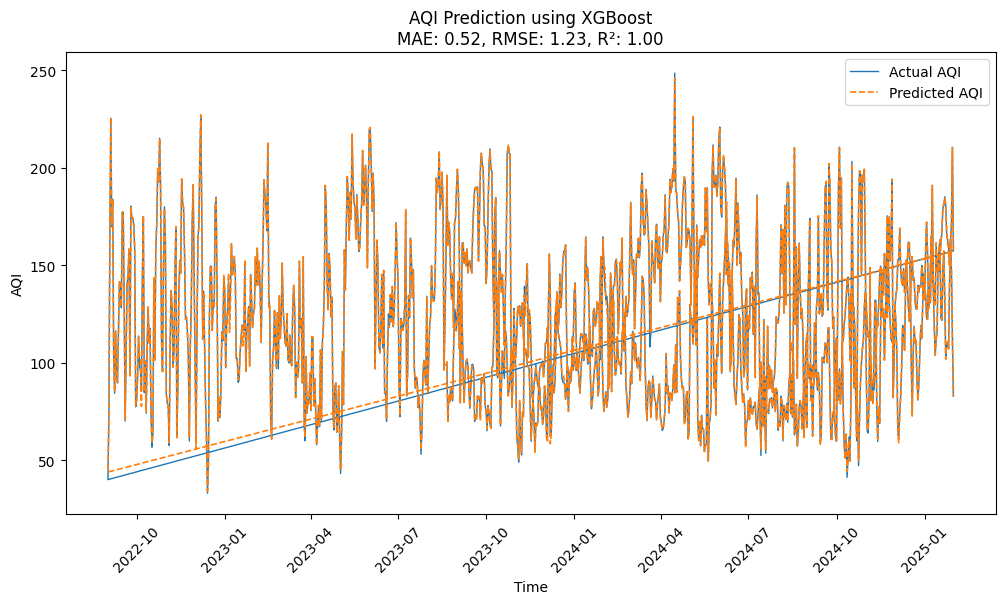

: 

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load Data
data = pd.read_csv("..//data/featureddata/featured_daily.csv", parse_dates=["time"])

# Feature Selection
target = 'AQI'
features = ['pm10 (μg/m³)', 'pm2_5 (μg/m³)', 'carbon_monoxide (μg/m³)', 'nitrogen_dioxide (μg/m³)',
            'sulphur_dioxide (μg/m³)', 'ozone (μg/m³)', 'PM2.5_SubIndex', 'PM10_SubIndex', 'CO_SubIndex',
            'Ozone_SubIndex', 'SO2_SubIndex', 'NOx_SubIndex', 'Urban/Rural', 'year', 'month', 'day', 'weekday',
            'AQI_lag_1', 'AQI_lag_7', 'AQI_lag_14', 'AQI_lag_30', 'AQI_7day_avg', 'AQI_30day_avg']

# Convert categorical features to numeric
data['Urban/Rural'] = data['Urban/Rural'].astype('category').cat.codes

# Drop missing values
# data = data.dropna()

# Train-Test Split
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(
    data[features], data[target], data["time"], test_size=0.4, random_state=42, shuffle=False
)

# Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.10f}")

# Plot Predictions with Timestamps
plt.figure(figsize=(12, 6))
plt.plot(time_test, y_test.values, label='Actual AQI', linewidth=1)
plt.plot(time_test, y_pred, label='Predicted AQI', linestyle='dashed', linewidth=1.2)
plt.legend()
plt.title(f"AQI Prediction using XGBoost\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load Data
data = pd.read_csv("..//data/featureddata/featured_daily.csv", parse_dates=["time"])

# Feature Selection
target = 'AQI'
features = ['pm10 (μg/m³)', 'pm2_5 (μg/m³)', 'carbon_monoxide (μg/m³)', 'nitrogen_dioxide (μg/m³)',
            'sulphur_dioxide (μg/m³)', 'ozone (μg/m³)', 'PM2.5_SubIndex', 'PM10_SubIndex', 'CO_SubIndex',
            'Ozone_SubIndex', 'SO2_SubIndex', 'NOx_SubIndex', 'Urban/Rural', 'year', 'month', 'day', 'weekday',
            'AQI_lag_1', 'AQI_lag_7', 'AQI_lag_14', 'AQI_lag_30', 'AQI_7day_avg', 'AQI_30day_avg']

# Convert categorical features to numeric
data['Urban/Rural'] = data['Urban/Rural'].astype('category').cat.codes

# Drop missing values
#data = data.dropna()

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Create adjacency matrix (dummy example: fully connected graph)
nodes = len(data)
adj_matrix = np.ones((nodes, nodes)) - np.eye(nodes)  # Fully connected graph without self-loops
edge_index = np.array(np.nonzero(adj_matrix))

# Convert data to PyTorch Geometric format
torch_data = Data(x=torch.tensor(data[features].values, dtype=torch.float),
                  edge_index=torch.tensor(edge_index, dtype=torch.long),
                  y=torch.tensor(data[target].values, dtype=torch.float))

# Train-Test Split
train_size = int(0.8 * nodes)
test_size = nodes - train_size
train_mask = torch.zeros(nodes, dtype=torch.bool)
train_mask[:train_size] = True
test_mask = ~train_mask

# Define GCN Model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x.squeeze()

# Model Initialization
model = GCN(input_dim=len(features), hidden_dim=32, output_dim=1)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.MSELoss()

# Training Loop
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    output = model(torch_data.x, torch_data.edge_index)
    loss = loss_fn(output[train_mask], torch_data.y[train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Evaluate Model
model.eval()
predictions = model(torch_data.x, torch_data.edge_index).detach().numpy()
y_true = torch_data.y.numpy()
mae = mean_absolute_error(y_true[test_mask], predictions[test_mask])
rmse = np.sqrt(mean_squared_error(y_true[test_mask], predictions[test_mask]))
print(f"MAE: {mae}, RMSE: {rmse}")

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_true[test_mask], label='Actual AQI')
plt.plot(predictions[test_mask], label='Predicted AQI', linestyle='dashed')
plt.legend()
plt.title("AQI Prediction using GCN")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.show()